Class distribution before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64


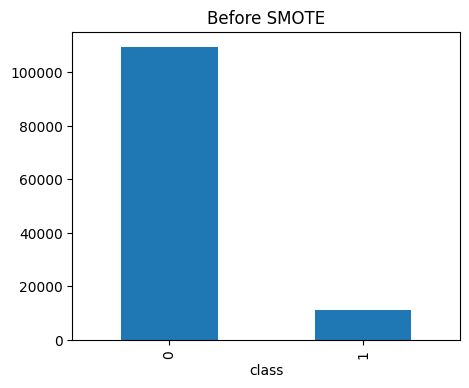


Class distribution after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64


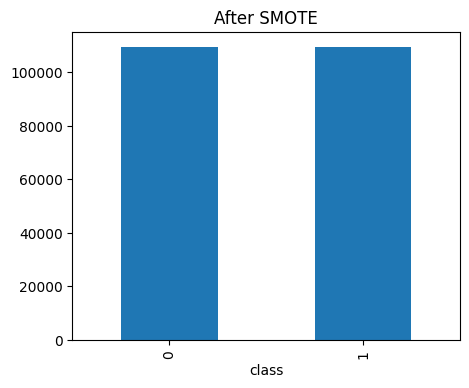

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     27393
           1       0.57      0.66      0.61      2830

    accuracy                           0.92     30223
   macro avg       0.77      0.80      0.78     30223
weighted avg       0.93      0.92      0.92     30223



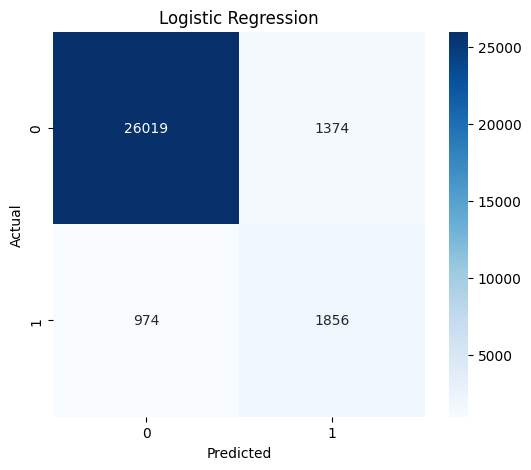

Logistic Regression AUC-PR: 0.6591
Logistic Regression F1: 0.6125

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.55      0.68      0.61      2830

    accuracy                           0.92     30223
   macro avg       0.76      0.81      0.78     30223
weighted avg       0.93      0.92      0.92     30223



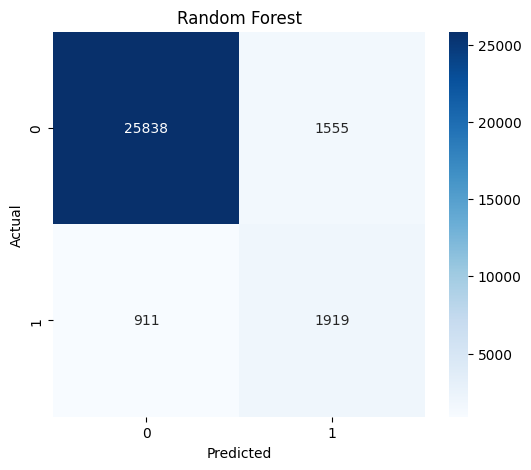

Random Forest AUC-PR: 0.7033
Random Forest F1: 0.6088



c:\Users\azeb.mehrete\Documents\KAIM\KAIM-5 and KAIM-6\w5-6env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:35:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.95      0.54      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



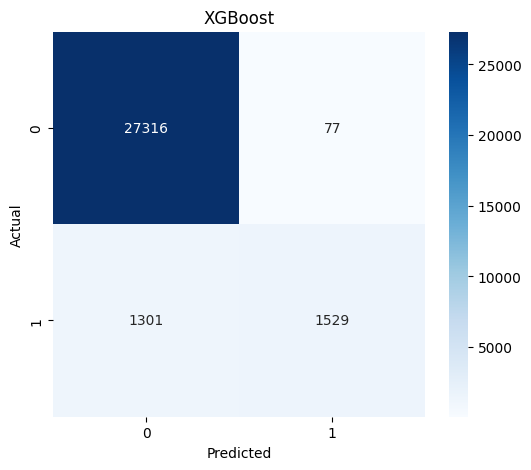

XGBoost AUC-PR: 0.7054
XGBoost F1: 0.6894

=== Cross-Validation (F1 Score) ===
Logistic Regression — Mean F1: 0.6308, Std: 0.0104
Random Forest — Mean F1: 0.6068, Std: 0.0045


c:\Users\azeb.mehrete\Documents\KAIM\KAIM-5 and KAIM-6\w5-6env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:45:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\azeb.mehrete\Documents\KAIM\KAIM-5 and KAIM-6\w5-6env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:45:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\azeb.mehrete\Documents\KAIM\KAIM-5 and KAIM-6\w5-6env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:45:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\azeb.mehrete\Documents\KAIM\KAIM-5 and KAIM-6\w5-6env\Lib\site-packages\xgboost\training.py:199: UserWarni

XGBoost — Mean F1: 0.6986, Std: 0.0050

=== Model Comparison ===
                 Model    AUC-PR  F1 Score  CV Mean F1  CV Std F1
0  Logistic Regression  0.659061  0.612541    0.630762   0.010370
1        Random Forest  0.703301  0.608820    0.606821   0.004549
2              XGBoost  0.705376  0.689360    0.698559   0.004986


In [8]:
# ===================================================
# LOAD LIBRARIES & PROCESSED FRAUD DATA
# ===================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    auc
)
from imblearn.over_sampling import SMOTE

# --------------------------------------------
# 1) LOAD PROCESSED DATA
# --------------------------------------------
fraud_df = pd.read_csv("../data/processed/fraud_data_with_country.csv")

# --------------------------------------------
# 2) FEATURE ENGINEERING
# --------------------------------------------

# Convert to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Time based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds()

# Transaction counts per user/device
fraud_df['user_txn_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')
fraud_df['device_txn_count'] = fraud_df.groupby('device_id')['purchase_time'].transform('count')

# Drop unneeded columns for modeling
fraud_df = fraud_df.drop(columns=['signup_time','purchase_time','lower','upper'])

# --------------------------------------------
# 3) DEFINE FEATURES & TARGET
# --------------------------------------------
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

# --------------------------------------------
# 4) TRAIN-TEST SPLIT (STRATIFIED)
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------------------------
# 5) IDENTIFY CATEGORICAL & NUMERIC FEATURES
# --------------------------------------------
cat_cols = ['source', 'browser', 'sex', 'country']
num_cols = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'time_since_signup',
    'user_txn_count',
    'device_txn_count'
]

# --------------------------------------------
# 6) DATA TRANSFORMATION PIPELINE
# --------------------------------------------
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# --------------------------------------------
# 7) CLASS DISTRIBUTION BEFORE SMOTE
# --------------------------------------------
print("Class distribution before SMOTE:")
print(y_train.value_counts())

plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar', title='Before SMOTE')
plt.show()

# --------------------------------------------
# 8) APPLY SMOTE ON TRAINING SET
# --------------------------------------------
smote = SMOTE(random_state=42)

# Preprocess and then resample
X_train_preprocessed = preprocess.fit_transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

plt.figure(figsize=(5,4))
pd.Series(y_train_resampled).value_counts().plot(kind='bar', title='After SMOTE')
plt.show()

# ===================================================
# TASK 2 — MODEL TRAINING & EVALUATION
# ===================================================

# Helper functions
def compute_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --------------------------------------------
# 1) BASELINE: LOGISTIC REGRESSION
# --------------------------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_lr = log_reg.predict(preprocess.transform(X_test))
y_scores_lr = log_reg.predict_proba(preprocess.transform(X_test))[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
plot_confusion(y_test, y_pred_lr, "Logistic Regression")

auc_pr_lr = compute_auc_pr(y_test, y_scores_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print(f"Logistic Regression AUC-PR: {auc_pr_lr:.4f}")
print(f"Logistic Regression F1: {f1_lr:.4f}\n")

# --------------------------------------------
# 2) ENSEMBLE: RANDOM FOREST
# --------------------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(preprocess.transform(X_test))
y_scores_rf = rf.predict_proba(preprocess.transform(X_test))[:,1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
plot_confusion(y_test, y_pred_rf, "Random Forest")

auc_pr_rf = compute_auc_pr(y_test, y_scores_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest AUC-PR: {auc_pr_rf:.4f}")
print(f"Random Forest F1: {f1_rf:.4f}\n")

# --------------------------------------------
# 3) ENSEMBLE: XGBOOST
# --------------------------------------------
xgb = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb.predict(preprocess.transform(X_test))
y_scores_xgb = xgb.predict_proba(preprocess.transform(X_test))[:,1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
plot_confusion(y_test, y_pred_xgb, "XGBoost")

auc_pr_xgb = compute_auc_pr(y_test, y_scores_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"XGBoost AUC-PR: {auc_pr_xgb:.4f}")
print(f"XGBoost F1: {f1_xgb:.4f}\n")

# --------------------------------------------
# 4) CROSS-VALIDATION (Stratified K-Fold)
# --------------------------------------------
print("=== Cross-Validation (F1 Score) ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, preprocess.transform(X), y, cv=skf, scoring='f1')
    cv_results[name] = scores
    print(f"{name} — Mean F1: {scores.mean():.4f}, Std: {scores.std():.4f}")

# --------------------------------------------
# 5) MODEL COMPARISON SUMMARY
# --------------------------------------------
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "AUC-PR": [auc_pr_lr, auc_pr_rf, auc_pr_xgb],
    "F1 Score": [f1_lr, f1_rf, f1_xgb],
    "CV Mean F1": [
        cv_results["Logistic Regression"].mean(),
        cv_results["Random Forest"].mean(),
        cv_results["XGBoost"].mean()
    ],
    "CV Std F1": [
        cv_results["Logistic Regression"].std(),
        cv_results["Random Forest"].std(),
        cv_results["XGBoost"].std()
    ]
})

print("\n=== Model Comparison ===")
print(comparison)


XGBoost is clearly performing best with 0.7054 AUC-PR and 0.6894 F1